<a href="https://colab.research.google.com/github/snehalmore/GEE_colab/blob/main/AEE_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name: Alpha Earth Embeddings for Plantations in AP/India

**Author:** Snehal More
**Date:** September 14, 2025




## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Modeling](#Modeling)
5. [Results](#Results)
6. [Conclusion](#Conclusion)


# 1. Introduction
<a id="Introduction"></a>
This notebook covers: accessing the Alpha Earth Embedding (AEE) data from Google Earth Engine, followed by visualization and analysis of 64 dimensional vecctor data for land cover classes.

In [39]:
%%capture --no-display
%pip install -U "geemap[workshop]" leafmap

### Import Libraries

In [40]:
import ee
import geemap

In [41]:
import pandas as pd

### GEE Authentication and Initialization

In [42]:
ee.Authenticate()

True

In [43]:
ee.Initialize(project="logical-bloom-433100-a7") # auto-created gee project name

In [44]:
## Function to extract coords
import json

## 2 Data Loading




### Import AlphaEarth Embeddings

In [45]:
dataset_cdq = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:

# Paste the copied path here
file_path = '/content/drive/MyDrive/AlphaEarth_test/AP_labels_all_2018.csv'
AP_labels = pd.read_csv(file_path)

In [48]:
# Display the first few rows of the DataFrame
print(AP_labels.head())

           system:index Class       District  FID1  FID_  Name        POINT_X  \
0  00006218d14fa81dad58     W            NaN     5   489   W42  608304.000009   
1  0000df7b46619be7bb63    AG            NaN    16   362  AG52  605079.000031   
2  00003effa3800fe70aa5    NF  East Godavari    13     0  NF52  596888.351200   
3  0000df39f488ce3e7963     W            NaN    10   469   W22  594719.999952   
4  000074bf193606e90132    UR            NaN     0   395  UR18  579364.000037   

        POINT_Y            Type  \
0  1.995629e+06           water   
1  1.978244e+06     agriculture   
2  1.984564e+06  Natural Forest   
3  1.987831e+06           water   
4  1.998447e+06           urban   

                                                .geo  
0  {"geodesic":true,"type":"Point","coordinates":...  
1  {"geodesic":true,"type":"Point","coordinates":...  
2  {"geodesic":true,"type":"Point","coordinates":...  
3  {"geodesic":true,"type":"Point","coordinates":...  
4  {"geodesic":true,"type":

[link text](https://)

In [49]:
# Function to extract coords safely
def extract_coords(value):
    try:
        data = json.loads(value)  # parse as JSON
        lon, lat = data["coordinates"]
        return pd.Series([lon, lat])
    except Exception as e:
        print("Parse error:", e, "Value:", value)  # debug
        return pd.Series([None, None])

# Add new columns to dataframe
AP_labels[["longitude", "latitude"]] = AP_labels[".geo"].apply(extract_coords)

# drop .geo column
AP_labels.drop(columns=[".geo"], inplace=True)

# Drop rows with NaN values in latitude or longitude
AP_labels.dropna(subset=["longitude", "latitude"], inplace=True)

# Fill missing values in 'District' column
AP_labels['District'].fillna('Unknown', inplace=True)


/tmp/ipython-input-1893781723.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AP_labels['District'].fillna('Unknown', inplace=True)


In [50]:
print(AP_labels.head())

           system:index Class       District  FID1  FID_  Name        POINT_X  \
0  00006218d14fa81dad58     W        Unknown     5   489   W42  608304.000009   
1  0000df7b46619be7bb63    AG        Unknown    16   362  AG52  605079.000031   
2  00003effa3800fe70aa5    NF  East Godavari    13     0  NF52  596888.351200   
3  0000df39f488ce3e7963     W        Unknown    10   469   W22  594719.999952   
4  000074bf193606e90132    UR        Unknown     0   395  UR18  579364.000037   

        POINT_Y            Type  longitude   latitude  
0  1.995629e+06           water  82.023284  18.046493  
1  1.978244e+06     agriculture  81.991944  17.889539  
2  1.984564e+06  Natural Forest  81.914923  17.947039  
3  1.987831e+06           water  81.894599  17.976657  
4  1.998447e+06           urban  81.749982  18.073215  


In [51]:
# Convert rows into EE Features
features = []
for _, row in AP_labels.iterrows():
    point = ee.Geometry.Point([row["longitude"], row["latitude"]])
    feature = ee.Feature(point, row.to_dict())  # attach attributes if needed
    features.append(feature)

AP_labels_fc = ee.FeatureCollection(features)

print(point)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Point",
    "arguments": {
      "coordinates": {
        "constantValue": [
          82.25780181248294,
          17.454063974764107
        ]
      }
    }
  }
})


In [52]:
unique_classes = AP_labels["Type"].unique()
print("Unique classes:", unique_classes)

Unique classes: ['water' 'agriculture' 'Natural Forest' 'urban' 'Casuarina' 'Eucalyptus'
 'Forest' 'sand' 'Agriculture' 'Urban']


In [53]:
# Generate distinct colors for each class
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

unique_classes = AP_labels["Type"].unique()

# Use a colormap and get colors
cmap = cm.get_cmap("tab10", len(unique_classes))
class_colors = {cls: colors.rgb2hex(cmap(i)) for i, cls in enumerate(unique_classes)}

/tmp/ipython-input-1384525458.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_classes))


In [96]:
# Create interactive map
center_lat = AP_labels_fc.aggregate_mean('latitude').getInfo()
center_lon = AP_labels_fc.aggregate_mean('longitude').getInfo()
Map = geemap.Map(center=[center_lat, center_lon], zoom=6)

Map.addLayer(dataset_cdq, {}, 'GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL') #Add AlphaEarth embedding layer

# Add each class with its unique color
for cls, color in class_colors.items():
    subset = AP_labels_fc.filter(ee.Filter.eq("Type", cls))
    Map.addLayer(subset, {"color": color}, cls)


Map

Map(center=[17.341694105951976, 81.69058214248822], controls=(WidgetControl(options=['position', 'transparent_…

In [65]:
# Filter the ImageCollection to get the image for 2018
dataset_2018 = dataset_cdq.filterDate('2018-01-01', '2018-12-31').first()

# Sample the image at the geometry of the first feature in AP_labels_fc
# Note: This samples only the first feature for demonstration.
# For all features, you would typically use map as done in cell AATWeTmeflHJ.
if dataset_2018:
    first_feature_geometry = AP_labels_fc.first().geometry()
    pixel_value = dataset_2018.sample(point).first().getInfo()
    print(pixel_value)
else:
    print("No image found for the year 2018.")

None


### extract the embedding value for given location
input: Latitude, Longitude, Start_date, End_date

In [79]:

point = ee.Geometry.Point(80.27709960937501,16.794023610508034)
# Load an example image
# img_collection = ee.collection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')

emb = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL') \
    .filterBounds(point)

image = emb.filterDate('2020-01-01', '2020-12-31').first()


pixel_value = image.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=10  # Use the image's native resolution or a suitable scale
).getInfo()

In [81]:
    print(pixel_value)

{'A00': -0.007443291041906958, 'A01': 0.03844675124951941, 'A02': 0.11909265667051133, 'A03': -0.017777777777777778, 'A04': -0.16000000000000003, 'A05': 0.13016532103037293, 'A06': 0.13016532103037293, 'A07': -0.029773164167627833, 'A08': -0.04822760476739715, 'A09': 0.17279507881584008, 'A10': 0.08882737408688965, 'A11': 0.1085121107266436, 'A12': -0.28444444444444444, 'A13': 0.16000000000000003, 'A14': 0.0629911572472126, 'A15': 0.21413302575932336, 'A16': -0.09356401384083046, 'A17': 0.10340638216070744, 'A18': -0.16000000000000003, 'A19': -0.06698961937716265, 'A20': -0.3553094963475586, 'A21': 0.3278123798539023, 'A22': -0.010396001537870049, 'A23': 0.09356401384083046, 'A24': -0.006151480199923107, 'A25': 0.11374086889657825, 'A26': 0.09356401384083046, 'A27': -0.0271280276816609, 'A28': 0.01574778931180315, 'A29': 0.041584006151480196, 'A30': 0.07111111111111111, 'A31': 0.1085121107266436, 'A32': -0.09356401384083046, 'A33': -0.01574778931180315, 'A34': 0.13016532103037293, 'A35

## Function to extract embedding value for given location

In [82]:
# Function to extract the embedding value for given location and date range
def extract_embedding_value(latitude, longitude, start_date, end_date):
    """
    Extracts the AlphaEarth embedding value for a given location and date range.

    Args:
        latitude (float): The latitude of the point.
        longitude (float): The longitude of the point.
        start_date (str): The start date of the date range (YYYY-MM-DD).
        end_date (str): The end date of the date range (YYYY-MM-DD).

    Returns:
        dict: A dictionary containing the sampled embedding values, or an empty dictionary if sampling fails.
    """
    point = ee.Geometry.Point(longitude, latitude)

    # Load and filter the ImageCollection by date and bounds
    emb = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL') \
        .filterDate(start_date, end_date) \
        .filterBounds(point)

    # Get the first image in the filtered collection
    image = emb.first()

    # Define a function to perform sampling and property extraction if the image exists
    def sample_and_extract(img, geom):
        sampled_feature_collection = img.sample(
            region=geom,
            scale=10, # Use a suitable scale, 10 or 30 is common for AlphaEarth
             geometries=False # No need to keep geometry in this case
        )
        # Get the first feature from the sampled collection
        sampled_feature = sampled_feature_collection.first()
        # Return the properties if the feature exists, otherwise an empty dictionary
        return ee.Algorithms.If(sampled_feature, sampled_feature.toDictionary(), ee.Dictionary({}))

    # Use ee.Algorithms.If to conditionally perform the sampling
    sampled_properties = ee.Algorithms.If(
        image, # Condition: if image is not null
        sample_and_extract(image, point), # True case: perform sampling and extract properties
        ee.Dictionary({}) # False case: return an empty dictionary
    )

    # Get the result on the client side
    ref_embedding_properties = sampled_properties.getInfo()

    # Return the extracted properties
    return ref_embedding_properties

## Extract Embeddings and Create New DataFrame with All Columns

### Subtask:
Iterate through the `AP_labels` DataFrame, extract embedding values using the `extract_embedding_value` function, and create a new DataFrame containing all original columns and the 64 embedding values.

**Reasoning**:
Iterate through each row of the `AP_labels` DataFrame. For each row, call the `extract_embedding_value` function with the latitude, longitude, and the desired date range (e.g., '2018-01-01' to '2018-12-31'). If embedding values are returned, create a dictionary for the current row by combining the original row's data with the extracted embedding values. Append this dictionary to a list. Finally, create a pandas DataFrame from the list of dictionaries and display the head and shape.

In [83]:
# Initialize a list to store the combined data for the new DataFrame
combined_data_for_new_df = []

# Define the date range for embedding extraction (assuming 2018 based on previous context)
start_date = '2018-01-01'
end_date = '2018-12-31'

# Iterate through each row of the AP_labels DataFrame
for index, row in AP_labels.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']

    # Extract embedding values using the function
    embedding_values = extract_embedding_value(latitude, longitude, start_date, end_date)

    # Check if embedding values were successfully extracted (dictionary is not empty)
    if embedding_values:
        # Create a dictionary for the current row by combining original data and embeddings
        row_data = row.to_dict() # Get original row data as a dictionary
        row_data.update(embedding_values) # Add embedding values to the dictionary
        combined_data_for_new_df.append(row_data)
    # Optional: handle rows where embedding extraction failed if needed

# Create a new pandas DataFrame from the combined data
final_dataframe_with_embeddings = pd.DataFrame(combined_data_for_new_df)

# Display the first few rows of the new DataFrame
print(final_dataframe_with_embeddings.head())

# Display the shape of the new DataFrame to confirm columns
print("Shape of the new DataFrame with embeddings:", final_dataframe_with_embeddings.shape)

           system:index Class       District  FID1  FID_  Name        POINT_X  \
0  00006218d14fa81dad58     W        Unknown     5   489   W42  608304.000009   
1  0000df7b46619be7bb63    AG        Unknown    16   362  AG52  605079.000031   
2  00003effa3800fe70aa5    NF  East Godavari    13     0  NF52  596888.351200   
3  0000df39f488ce3e7963     W        Unknown    10   469   W22  594719.999952   
4  000074bf193606e90132    UR        Unknown     0   395  UR18  579364.000037   

        POINT_Y            Type  longitude  ...       A54       A55       A56  \
0  1.995629e+06           water  82.023284  ...  0.113741 -0.006151 -0.038447   
1  1.978244e+06     agriculture  81.991944  ...  0.276140 -0.003937 -0.000554   
2  1.984564e+06  Natural Forest  81.914923  ...  0.228897 -0.038447  0.015748   
3  1.987831e+06           water  81.894599  ...  0.119093 -0.007443 -0.059116   
4  1.998447e+06           urban  81.749982  ...  0.153787 -0.192910  0.032541   

        A57       A58     

# Task
Visualize the AlphaEarth embeddings by plotting the relationship between the 'Type' column and the 64 embedding band values in the `final_dataframe_with_embeddings` DataFrame.

## Select embedding band columns

### Subtask:
Identify the columns in `final_dataframe_with_embeddings` that contain the 64 embedding values.


**Reasoning**:
Identify the columns in `final_dataframe_with_embeddings` that contain the 64 embedding values by checking for column names that start with 'A' followed by numbers '00' through '63'.



In [84]:
# Identify the embedding columns
embedding_columns = [col for col in final_dataframe_with_embeddings.columns if col.startswith('A') and col[1:].isdigit() and int(col[1:]) < 64]

# Print the identified embedding columns to verify
print("Identified embedding columns:", embedding_columns)

Identified embedding columns: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']


## Calculate summary statistics per type

### Subtask:
Calculate mean or median values of the embedding bands for each unique 'Type' category.


**Reasoning**:
Calculate the mean of the embedding bands for each unique 'Type' category by grouping the DataFrame by 'Type' and applying the mean aggregation to the identified embedding columns.



In [85]:
# Group the DataFrame by 'Type' and calculate the mean of the embedding columns
embedding_means_by_type = final_dataframe_with_embeddings.groupby('Type')[embedding_columns].mean()

# Print the head of the resulting DataFrame to inspect the results
print(embedding_means_by_type.head())

                     A00       A01       A02       A03       A04       A05  \
Type                                                                         
Agriculture    -0.009003 -0.040730  0.198465 -0.029347 -0.088463  0.088013   
Casuarina       0.010959 -0.151960  0.140789 -0.005598 -0.068987  0.045514   
Eucalyptus     -0.003301 -0.079511  0.127698  0.009029 -0.101568  0.078390   
Forest          0.014531 -0.126399  0.171146 -0.017652 -0.074182  0.026958   
Natural Forest  0.031788 -0.132940  0.113555  0.003679 -0.051003 -0.069702   

                     A06       A07       A08       A09  ...       A54  \
Type                                                    ...             
Agriculture     0.069247  0.067980 -0.053721  0.095396  ...  0.230277   
Casuarina       0.010137  0.131092 -0.106143  0.158513  ...  0.201854   
Eucalyptus      0.074474  0.128846 -0.124041  0.111164  ...  0.221877   
Forest          0.020205  0.139273 -0.107651  0.088414  ...  0.187519   
Natural Forest 

## Visualize summary statistics

### Subtask:
Create a plot (e.g., a bar plot or a heatmap) to visualize the summary statistics of the embedding bands across different 'Type' categories.


**Reasoning**:
Create a heatmap of the mean embedding values by land cover type to visualize the relationships between types and embedding dimensions.



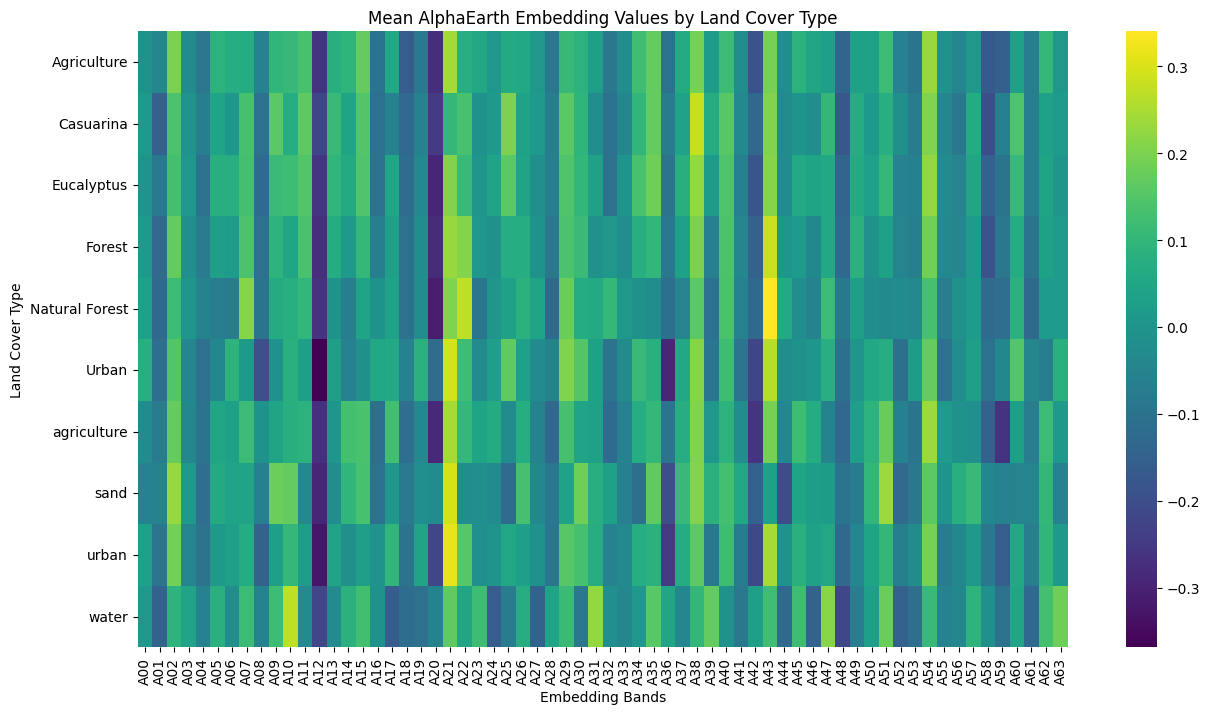

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the embedding means by type
plt.figure(figsize=(15, 8)) # Adjust figure size for better readability
sns.heatmap(embedding_means_by_type, cmap='viridis') # Use a suitable colormap
plt.title("Mean AlphaEarth Embedding Values by Land Cover Type")
plt.xlabel("Embedding Bands")
plt.ylabel("Land Cover Type")
plt.show()

**Reasoning**:
The previous attempt failed because the seaborn library was not imported. Import seaborn and matplotlib.pyplot and then recreate the heatmap.



## Perform Dimensionality Reduction (t-SNE)

### Subtask:
Apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the embedding band values to reduce the dimensionality for visualization.

**Reasoning**:
Use scikit-learn's TSNE to reduce the 64 embedding dimensions to 2 components for 2D visualization.

In [88]:
from sklearn.manifold import TSNE
import numpy as np

# Select only the embedding columns for t-SNE
embedding_data = final_dataframe_with_embeddings[embedding_columns].dropna()

# Ensure there are enough samples for t-SNE (typically n_components < n_samples)
# And that perplexity is less than the number of samples
n_components = 2
perplexity_value = 30 # A common value, adjust if needed

if embedding_data.shape[0] > n_components and embedding_data.shape[0] > perplexity_value:
    # Initialize t-SNE and fit on the embedding data
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=perplexity_value)
    tsne_components = tsne.fit_transform(embedding_data)

    # Create a new DataFrame with the t-SNE components
    tsne_df = pd.DataFrame(data = tsne_components, columns = [f'tsne_component_{i+1}' for i in range(n_components)])

    # Add the 'Type' column to the t-SNE DataFrame for visualization
    # Align the 'Type' column with the rows that had valid embeddings and were used for t-SNE
    original_types = final_dataframe_with_embeddings.loc[embedding_data.index, 'Type'].reset_index(drop=True)
    tsne_df['Type'] = original_types

    print("t-SNE Components DataFrame Head:")
    print(tsne_df.head())

else:
    print("Not enough data to perform t-SNE with the current parameters. Check the number of rows after handling NaNs or adjust perplexity.")

t-SNE Components DataFrame Head:
   tsne_component_1  tsne_component_2            Type
0         49.669338          0.517346           water
1         -2.276645          4.223248     agriculture
2        -20.352411         12.763591  Natural Forest
3         49.270470         -0.862101           water
4         -3.334457         19.469641           urban


# Task
Create a 3D interactive t-SNE plot of the embedding band values from the `AP_labels` DataFrame, colored by the 'Type' column.

## Perform t-sne (3 components)

### Subtask:
Apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the embedding band values, reducing the dimensionality to 3 components.


**Reasoning**:
Apply t-SNE with 3 components to the embedding data to reduce dimensionality for 3D visualization.



In [89]:
# Select only the embedding columns for t-SNE
embedding_data = final_dataframe_with_embeddings[embedding_columns].dropna()

# Ensure there are enough samples for t-SNE (typically n_components < n_samples)
# And that perplexity is less than the number of samples
n_components_3d = 3
perplexity_value = 30 # A common value, adjust if needed

if embedding_data.shape[0] > n_components_3d and embedding_data.shape[0] > perplexity_value:
    # Initialize t-SNE with 3 components and fit on the embedding data
    tsne_3d = TSNE(n_components=n_components_3d, random_state=42, perplexity=perplexity_value)
    tsne_components_3d = tsne_3d.fit_transform(embedding_data)

    # Create a new DataFrame with the 3 t-SNE components
    tsne_df_3d = pd.DataFrame(data = tsne_components_3d, columns = [f'tsne_component_{i+1}' for i in range(n_components_3d)])

    # Add the 'Type' column to the t-SNE DataFrame for visualization
    # Align the 'Type' column with the rows that had valid embeddings and were used for t-SNE
    original_types_3d = final_dataframe_with_embeddings.loc[embedding_data.index, 'Type'].reset_index(drop=True)
    tsne_df_3d['Type'] = original_types_3d

    print("3D t-SNE Components DataFrame Head:")
    print(tsne_df_3d.head())

    print("\nShape of the 3D t-SNE DataFrame:", tsne_df_3d.shape)

else:
    print("Not enough data to perform 3D t-SNE with the current parameters. Check the number of rows after handling NaNs or adjust perplexity.")

3D t-SNE Components DataFrame Head:
   tsne_component_1  tsne_component_2  tsne_component_3            Type
0         17.622324         -0.826546          3.587337           water
1          0.449237          1.714332         -4.809230     agriculture
2         -7.371515          7.063545         -0.952632  Natural Forest
3         17.230349         -1.544375          3.328095           water
4          1.545582          8.968600         -5.762661           urban

Shape of the 3D t-SNE DataFrame: (507, 4)


## Prepare data for 3d plotting

### Subtask:
Create a DataFrame or data structure suitable for 3D plotting, including the 3 t-SNE components and the 'Type' column.


**Reasoning**:
Verify the structure and content of the `tsne_df_3d` DataFrame to ensure it's suitable for 3D plotting.



In [90]:
# Verify the columns and data types
print(tsne_df_3d.info())

# Check the unique values and their counts in the 'Type' column
print("\nUnique values and counts in 'Type' column:")
print(tsne_df_3d['Type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tsne_component_1  507 non-null    float32
 1   tsne_component_2  507 non-null    float32
 2   tsne_component_3  507 non-null    float32
 3   Type              507 non-null    object 
dtypes: float32(3), object(1)
memory usage: 10.0+ KB
None

Unique values and counts in 'Type' column:
Type
Casuarina         192
urban              70
water              59
Agriculture        50
Natural Forest     50
Forest             50
sand               14
Urban              10
Eucalyptus          9
agriculture         3
Name: count, dtype: int64


## Create 3d interactive scatter plot

### Subtask:
Generate a 3D interactive scatter plot using Plotly or a similar library, with the 3 t-SNE components as axes and points colored by 'Type'.


**Reasoning**:
Generate a 3D interactive scatter plot using Plotly with the 3 t-SNE components as axes and points colored by 'Type'.



In [91]:
import plotly.express as px

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    tsne_df_3d,
    x='tsne_component_1',
    y='tsne_component_2',
    z='tsne_component_3',
    color='Type', # Color points by the 'Type' column
    title='3D t-SNE of AlphaEarth Embeddings by Land Cover Type'
)

# Display the interactive plot
fig.show()

## Summary:

### Data Analysis Key Findings

*   The 3D t-SNE transformation was successfully applied to the embedding band values, reducing the dimensionality to 3 components for 507 data points.
*   The resulting 3D t-SNE components were stored in a DataFrame along with their corresponding 'Type' labels, confirming the correct data structure for plotting.
*   The 'Type' column contains several unique values, indicating different land cover types that will be used for coloring in the plot.
*   An interactive 3D scatter plot was successfully generated using Plotly Express, visualizing the distribution of data points in the 3D t-SNE space, colored by their respective 'Type'.

### Insights or Next Steps

*   The 3D t-SNE plot provides a visual representation of how different land cover types are clustered in the embedding space, which can help assess the separability of classes based on the embeddings.
*   Further analysis could involve examining the clusters to understand which land cover types are well-separated and which ones overlap, potentially informing improvements to the embedding process or classification models.


# Task
Perform UMAP dimensionality reduction on the embedding band values to 3 components and create a 3D interactive scatter plot of the results, colored by the 'Type' column.

## Install umap library

### Subtask:
Install the `umap-learn` library as it's not a standard library in Colab.


**Reasoning**:
Install the `umap-learn` library using pip.



In [92]:
%pip install umap-learn

## Perform umap (3 components)

### Subtask:
Apply Uniform Manifold Approximation and Projection (UMAP) to the embedding band values, reducing the dimensionality to 3 components.


**Reasoning**:
Apply UMAP with 3 components to the embedding data to reduce dimensionality for 3D visualization.



In [93]:
from umap import UMAP
import numpy as np

# Select only the embedding columns for UMAP
embedding_data = final_dataframe_with_embeddings[embedding_columns].dropna()

# Initialize UMAP with 3 components
umap_3d = UMAP(n_components=3, random_state=42)

# Fit UMAP and transform the data
umap_components_3d = umap_3d.fit_transform(embedding_data)

# Create a new DataFrame with the 3 UMAP components
umap_df_3d = pd.DataFrame(data = umap_components_3d, columns = [f'umap_component_{i+1}' for i in range(3)])

# Print the head and shape of the new DataFrame
print("3D UMAP Components DataFrame Head:")
print(umap_df_3d.head())

print("\nShape of the 3D UMAP DataFrame:", umap_df_3d.shape)

3D UMAP Components DataFrame Head:
   umap_component_1  umap_component_2  umap_component_3
0         16.350321          3.672900          1.920388
1          0.669074         10.595905          4.123616
2         -0.077002         15.663019          4.832753
3         16.357492          3.697222          1.943902
4          2.298781         10.694929          6.614689

Shape of the 3D UMAP DataFrame: (507, 3)


## Prepare data for 3d plotting

### Subtask:
Create a DataFrame or data structure suitable for 3D plotting, including the 3 UMAP components and the 'Type' column.


**Reasoning**:
Add the 'Type' column to the umap_df_3d DataFrame, verify the DataFrame's structure and content, and check the distribution of land cover types.



In [94]:
# Add the 'Type' column to the UMAP DataFrame for visualization
# Align the 'Type' column with the rows that had valid embeddings and were used for UMAP
original_types_umap = final_dataframe_with_embeddings.loc[embedding_data.index, 'Type'].reset_index(drop=True)
umap_df_3d['Type'] = original_types_umap

# Verify the columns and data types
print(umap_df_3d.info())

# Check the unique values and their counts in the 'Type' column
print("\nUnique values and counts in 'Type' column:")
print(umap_df_3d['Type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   umap_component_1  507 non-null    float32
 1   umap_component_2  507 non-null    float32
 2   umap_component_3  507 non-null    float32
 3   Type              507 non-null    object 
dtypes: float32(3), object(1)
memory usage: 10.0+ KB
None

Unique values and counts in 'Type' column:
Type
Casuarina         192
urban              70
water              59
Agriculture        50
Natural Forest     50
Forest             50
sand               14
Urban              10
Eucalyptus          9
agriculture         3
Name: count, dtype: int64


## Create 3d interactive scatter plot

### Subtask:
Generate a 3D interactive scatter plot using Plotly or a similar library, with the 3 UMAP components as axes and points colored by 'Type'.


**Reasoning**:
Generate a 3D interactive scatter plot using Plotly with the 3 UMAP components as axes and points colored by 'Type'.



In [95]:
import plotly.express as px

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    umap_df_3d,
    x='umap_component_1',
    y='umap_component_2',
    z='umap_component_3',
    color='Type', # Color points by the 'Type' column
    title='3D UMAP of AlphaEarth Embeddings by Land Cover Type'
)

# Display the interactive plot
fig.show()

## Summary:

### Data Analysis Key Findings

*   UMAP dimensionality reduction was successfully applied to the embedding band values, reducing them to 3 components.
*   A DataFrame was created containing the 3 UMAP components and the corresponding 'Type' column, which includes land cover types such as 'Casuarina', 'urban', 'water', 'Agriculture', 'Natural Forest', 'Forest', 'sand', 'Urban', 'Eucalyptus', and 'agriculture'.
*   A 3D interactive scatter plot was generated using Plotly, visualizing the 3 UMAP components on the axes and coloring the points by their 'Type'.

### Insights or Next Steps

*   The 3D UMAP plot can be used to visually assess how well the embedding space separates different land cover types. Clusters of similar colors would suggest that the embeddings effectively capture distinct features for those types.
*   Further analysis could involve quantitative evaluation of the separation of clusters in the UMAP space, perhaps using clustering algorithms or metrics like silhouette scores, to objectively measure the effectiveness of the embeddings for land cover classification.


In [98]:
import os

# Define the output directory in Google Drive
output_drive_dir = '/content/drive/MyDrive/AlphaEarth_test/'

# Ensure the output directory exists (optional, but good practice)
os.makedirs(output_drive_dir, exist_ok=True)

# Identify the columns to include in the TSV file
# These are latitude, longitude, Type, and the 64 embedding band columns
# Assuming embedding_columns is defined from earlier steps
columns_to_include_drive = ['latitude', 'longitude', 'Type'] + embedding_columns

# Create a new DataFrame with the selected columns
tsv_drive_data_df = final_dataframe_with_embeddings[columns_to_include_drive].copy()

# Define the full output file path with the new name
output_tsv_drive_path = os.path.join(output_drive_dir, 'tsv_emb_data.tsv') # Changed file name here

# Save the DataFrame as a TSV file to Google Drive
tsv_drive_data_df.to_csv(output_tsv_drive_path, sep='\t', index=False)

print(f"TSV file with metadata and embeddings saved to {output_tsv_drive_path}")

# Optional: Display the first few rows of the new DataFrame to verify
print("\nHead of the TSV data DataFrame saved to Drive:")
print(tsv_drive_data_df.head())

TSV file with metadata and embeddings saved to /content/drive/MyDrive/AlphaEarth_test/tsv_emb_data.tsv

Head of the TSV data DataFrame saved to Drive:
    latitude  longitude            Type       A00       A01       A02  \
0  18.046493  82.023284           water -0.019931 -0.199862  0.038447   
1  17.889539  81.991944     agriculture -0.013841 -0.044844  0.108512   
2  17.947039  81.914923  Natural Forest  0.044844 -0.103406  0.093564   
3  17.976657  81.894599           water  0.029773 -0.119093  0.075356   
4  18.073215  81.749982           urban  0.062991 -0.147697  0.103406   

        A03       A04       A05       A06  ...       A54       A55       A56  \
0  0.075356 -0.022207  0.048228 -0.022207  ...  0.113741 -0.006151 -0.038447   
1 -0.012057 -0.027128  0.038447  0.051734  ...  0.276140 -0.003937 -0.000554   
2  0.015748 -0.044844 -0.108512 -0.166336  ...  0.228897 -0.038447  0.015748   
3  0.032541 -0.022207  0.044844 -0.012057  ...  0.119093 -0.007443 -0.059116   
4 -0.00885